<a href="https://colab.research.google.com/github/arielwendichansky/DI_Bootcamp/blob/master/Week9/Day5/MiniProject2/Customer_Feedback_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [2]:
# Gemini model
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.1/679.1 kB 8.7 MB/s eta 0:00:00


In [3]:
# For NLP
!pip install nltk

# Libraries

In [4]:

# Data manipulation
import numpy as np
import pandas as pd

# Plotting data
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from plotnine import (ggplot,aes,geom_line,facet_wrap,labs, scale_x_datetime, element_text, theme_538)
from plotnine.data import meat

# Statistic data
from scipy import stats, cluster
from scipy.optimize import minimize_scalar
from scipy.stats import skew, kurtosis, median_test,ttest_ind, norm

# Machine Learning
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from collections import Counter

# Gemini packages

import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


# Used to securely store your API key
from google.colab import userdata


# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)


import os
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

# Import NLTK libraries for NLP

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize,sent_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Kaggle

In [5]:
!pip install kaggle

from google.colab import userdata
userdata.get('Kaggle')

'35f486beabeea6fcb79285bc7f95d018'

In [6]:
! kaggle datasets download -d eswarchandt/amazon-music-reviews

Dataset URL: https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews
License(s): CC0-1.0
  0% 0.00/4.69M [00:00<?, ?B/s]
100% 4.69M/4.69M [00:00<00:00, 63.1MB/s]


In [7]:
! unzip 'amazon-music-reviews.zip'

Archive:  amazon-music-reviews.zip
  inflating: Musical_Instruments_5.json  
  inflating: Musical_instruments_reviews.csv  


# Data inspection

In [8]:
df = pd.read_csv('Musical_instruments_reviews.csv')

In [9]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
overall,10261.0,4.488744e+00,8.946424e-01,1.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
unixReviewTime,10261.0,1.360606e+09,3.779735e+07,1.095466e+09,1.343434e+09,1.368490e+09,1.388966e+09,1.405987e+09


In [12]:
# Time to data type
df['reviewTime'] = pd.to_datetime(df['reviewTime'])


In [13]:
df.duplicated().sum()

0

In [14]:
df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [15]:
# Dropping null values for review text column
df = df.dropna(subset=['reviewText'])

# Data preparation

## Tokenized column

In [17]:
#Using subsample to tokenize
df_subsamp = df.head(51)

# Apply word_tokenize to each element in the 'reviewText' column using .loc to avoid the warning
df_subsamp.loc[:, 'Token_review'] = df_subsamp['reviewText'].apply(word_tokenize)

df_subsamp

<ipython-input-17-fcb4e8623639>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,Token_review
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,2014-02-28,"[Not, much, to, write, about, here, ,, but, it..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,2013-03-16,"[The, product, does, exactly, as, it, should, ..."
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,2013-08-28,"[The, primary, job, of, this, device, is, to, ..."
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,2014-02-14,"[Nice, windscreen, protects, my, MXL, mic, and..."
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,2014-02-21,"[This, pop, filter, is, great, ., It, looks, a..."
5,A2A039TZMZHH9Y,B00004Y2UT,"Bill Lewey ""blewey""","[0, 0]",So good that I bought another one. Love the h...,5.0,The Best Cable,1356048000,2012-12-21,"[So, good, that, I, bought, another, one, ., L..."
6,A1UPZM995ZAH90,B00004Y2UT,Brian,"[0, 0]","I have used monster cables for years, and with...",5.0,Monster Standard 100 - 21' Instrument Cable,1390089600,2014-01-19,"[I, have, used, monster, cables, for, years, ,..."
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",I now use this cable to run from the output of...,3.0,Didn't fit my 1996 Fender Strat...,1353024000,2012-11-16,"[I, now, use, this, cable, to, run, from, the,..."
8,A3M1PLEYNDEYO8,B00004Y2UT,"G. Thomas ""Tom""","[0, 0]",Perfect for my Epiphone Sheraton II. Monster ...,5.0,Great cable,1215302400,2008-07-06,"[Perfect, for, my, Epiphone, Sheraton, II, ., ..."
9,AMNTZU1YQN1TH,B00004Y2UT,Kurt Robair,"[0, 0]",Monster makes the best cables and a lifetime w...,5.0,Best Instrument Cables On The Market,1389139200,2014-01-08,"[Monster, makes, the, best, cables, and, a, li..."


# Sentiment analysis with Gemini

In [61]:
# I will test the model with the reviews tokenized and not tokenized and to see how it performs
list_review_token = df_subsamp['Token_review']

reviews = df_subsamp['reviewText']
reviews

0     Not much to write about here, but it does exac...
1     The product does exactly as it should and is q...
2     The primary job of this device is to block the...
3     Nice windscreen protects my MXL mic and preven...
4     This pop filter is great. It looks and perform...
5     So good that I bought another one.  Love the h...
6     I have used monster cables for years, and with...
7     I now use this cable to run from the output of...
8     Perfect for my Epiphone Sheraton II.  Monster ...
9     Monster makes the best cables and a lifetime w...
10    Monster makes a wide array of cables, includin...
11    I got it to have it if I needed it. I have fou...
12    If you are not use to using a large sustaining...
13    I love it, I used this for my Yamaha ypt-230 a...
14    I bought this to use in my home studio to cont...
15    I bought this to use with my keyboard. I wasn'...
16    This Fender cable is the perfect length for me...
17    wanted it just on looks alone...It is a ni

In [65]:
#NOT TOKENIZED
model = genai.GenerativeModel('gemini-pro')
response = model.generate_content(f'''You are working in the area of marketing from a company. The area is looking to improve their services based on the reviews from their customers.
You need to analyze this reviews and provide a sentimental analysis for each of the following reviews {reviews.to_string()}. Say which are the common themes repeated the most.
For each review, locate this in a theme (for example Aesthetics, Value, Quality, Functionality) . Improvement or suggestions based on the data? Remember there are 51 reviews from 0 to 50''')
to_markdown(response.text)

> **Review 0**
> 
> * Sentiment: Neutral
> * Theme: Functionality
> * Improvement: Provide more details about the product's features and benefits.
> 
> **Review 1**
> 
> * Sentiment: Positive
> * Theme: Functionality and Quality
> * Improvement: None
> 
> **Review 2**
> 
> * Sentiment: Positive
> * Theme: Functionality
> * Improvement: Highlight the product's effectiveness in blocking the wind.
> 
> **Review 3**
> 
> * Sentiment: Positive
> * Theme: Quality and Functionality
> * Improvement: Emphasize the product's durability and protection for the microphone.
> 
> **Review 4**
> 
> * Sentiment: Positive
> * Theme: Aesthetics and Functionality
> * Improvement: Showcase the product's stylish design and performance.
> 
> **Review 5**
> 
> * Sentiment: Positive
> * Theme: Value and Functionality
> * Improvement: Promote the product's affordable price and versatility.
> 
> **Review 6**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Highlight the product's reliability and lifetime warranty.
> 
> **Review 7**
> 
> * Sentiment: Positive
> * Theme: Functionality and Value
> * Improvement: Explain how the product seamlessly connects devices.
> 
> **Review 8**
> 
> * Sentiment: Positive
> * Theme: Aesthetics and Quality
> * Improvement: Emphasize the product's compatibility with Epiphone Sheraton II.
> 
> **Review 9**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Promote the product's exceptional construction and warranty.
> 
> **Review 10**
> 
> * Sentiment: Positive
> * Theme: Value and Functionality
> * Improvement: Showcase the product's wide range of applications.
> 
> **Review 11**
> 
> * Sentiment: Neutral
> * Theme: Functionality
> * Improvement: Explain the product's potential uses and value.
> 
> **Review 12**
> 
> * Sentiment: Neutral
> * Theme: Functionality
> * Improvement: Provide clear instructions on how to use the product effectively.
> 
> **Review 13**
> 
> * Sentiment: Positive
> * Theme: Functionality and Value
> * Improvement: Emphasize the product's ease of use and affordability.
> 
> **Review 14**
> 
> * Sentiment: Positive
> * Theme: Functionality and Value
> * Improvement: Highlight the product's versatility in home studio applications.
> 
> **Review 15**
> 
> * Sentiment: Positive
> * Theme: Functionality and Value
> * Improvement: Showcase the product's compatibility with keyboards.
> 
> **Review 16**
> 
> * Sentiment: Positive
> * Theme: Aesthetics and Functionality
> * Improvement: Emphasize the product's ideal length and visual appeal.
> 
> **Review 17**
> 
> * Sentiment: Positive
> * Theme: Aesthetics and Value
> * Improvement: Highlight the product's unique design and affordable price.
> 
> **Review 18**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Promote the product's durability and longevity.
> 
> **Review 19**
> 
> * Sentiment: Positive
> * Theme: Aesthetics and Functionality
> * Improvement: Emphasize the product's great looks and performance.
> 
> **Review 20**
> 
> * Sentiment: Positive
> * Theme: Aesthetics and Value
> * Improvement: Promote the product's cool design and budget-friendly price.
> 
> **Review 21**
> 
> * Sentiment: Positive
> * Theme: Aesthetics and Functionality
> * Improvement: Highlight the product's stylish design and clear sound transmission.
> 
> **Review 22**
> 
> * Sentiment: Positive
> * Theme: Quality and Aesthetics
> * Improvement: Emphasize the product's well-made construction and attractive appearance.
> 
> **Review 23**
> 
> * Sentiment: Positive
> * Theme: Functionality and Value
> * Improvement: Showcase the product's ability to run keyboard controllers.
> 
> **Review 24**
> 
> * Sentiment: Positive
> * Theme: Functionality and Value
> * Improvement: Promote the product's compatibility with AR modules.
> 
> **Review 25**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Emphasize the product's high quality at an affordable price.
> 
> **Review 26**
> 
> * Sentiment: Positive
> * Theme: Quality and Functionality
> * Improvement: Highlight the product's durable construction and reliable performance.
> 
> **Review 27**
> 
> * Sentiment: Positive
> * Theme: Functionality
> * Improvement: Explain how the product simplifies MIDI connections.
> 
> **Review 28**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Promote the product's affordability and high quality.
> 
> **Review 29**
> 
> * Sentiment: Positive
> * Theme: Functionality and Value
> * Improvement: Showcase the product's ability to connect boards to amps.
> 
> **Review 30**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Emphasize the product's sturdy construction and low price.
> 
> **Review 31**
> 
> * Sentiment: Positive
> * Theme: Quality and Functionality
> * Improvement: Highlight the product's reliability and durability.
> 
> **Review 32**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Promote the product's good value for the price.
> 
> **Review 33**
> 
> * Sentiment: Positive
> * Theme: Functionality and Value
> * Improvement: Showcase the product's ability to connect vocals and instruments.
> 
> **Review 34**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Emphasize the product's durability and affordability.
> 
> **Review 35**
> 
> * Sentiment: Positive
> * Theme: Quality and Durability
> * Improvement: Promote the product's long-lasting construction.
> 
> **Review 36**
> 
> * Sentiment: Neutral
> * Theme: Quality and Value
> * Improvement: Explain how the product meets expectations despite being inexpensive.
> 
> **Review 37**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Promote the product's good quality at a reasonable price.
> 
> **Review 38**
> 
> * Sentiment: Positive
> * Theme: Quality and Functionality
> * Improvement: Highlight the product's reliable performance and versatility.
> 
> **Review 39**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Emphasize the product's superior quality compared to cheaper alternatives.
> 
> **Review 40**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Promote the product's sturdy construction and excellent customer support.
> 
> **Review 41**
> 
> * Sentiment: Positive
> * Theme: Quality and Sound
> * Improvement: Highlight the product's high-quality construction and excellent sound transmission.
> 
> **Review 42**
> 
> * Sentiment: Positive
> * Theme: Quality and Durability
> * Improvement: Promote the product's sturdy construction and reliable performance.
> 
> **Review 43**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Showcase the product's affordable price and good quality.
> 
> **Review 44**
> 
> * Sentiment: Neutral
> * Theme: Value
> * Improvement: Explain how the product meets expectations for a budget-friendly replacement.
> 
> **Review 45**
> 
> * Sentiment: Positive
> * Theme: Quality and Value
> * Improvement: Promote the product's affordability and high quality.
> 
> **Review 46**
> 
> * Sentiment: Positive
> * Theme: Quality and Design
> * Improvement: Showcase the product's durable construction and stylish design.
> 
> **Review 47**
> 
> * Sentiment: Positive
> * Theme: Quality and Functionality
> * Improvement: Highlight the product's sturdiness and lack of noise issues.
> 
> **Review 48**
> 
> * Sentiment: Positive
> * Theme: Quality and Functionality
> * Improvement: Promote the product's reliability and ease of use for non-professionals.
> 
> **Review 49**
> 
> * Sentiment: Positive
> * Theme: Quality and Construction
> * Improvement: Highlight the product's well-made construction and high quality.
> 
> **Review 50**
> 
> * Sentiment: Positive
> * Theme: Quality and Aesthetics
> * Improvement: Emphasize the product's thin profile and surprising durability.
> 
> **Common Themes**
> 
> * Quality (25 reviews)
> * Value (16 reviews)
> * Functionality (14 reviews)
> * Aesthetics (10 reviews)
> * Durability (7 reviews)
> * Sound (3 reviews)
> * Design (3 reviews)
> * Construction (2 reviews)
> * Support (1 review)
> 
> **Improvement Suggestions**
> 
> * Highlight the product's durability and reliability in all reviews.
> * Emphasize the product's value for the price, especially in positive reviews.
> * Provide more details about the product's functionality and features.
> * Showcase the product's stylish design and aesthetic appeal.
> * Promote customer support services to enhance the overall customer experience.

In [34]:
#TOKENIZED
model = genai.GenerativeModel('gemini-pro')
response = model.generate_content(f'''You are working in the area of marketing from a company. The area is looking to improve their services based on the reviews from their customers.
You need to analyze this reviews and provide a sentimental analysis for each of the following reviews {list_review.to_string()}
Is there any common themes? improvement or suggestions based on the data?
Devide the different reviews by categories based on what the user said''')
to_markdown(response.text)

> **Review Sentimental Analysis**
> 
> * 0: Neutral
> * 1: Positive
> * 2: Positive
> * 3: Positive
> * 4: Positive
> * 5: Positive
> * 6: Positive
> * 7: Positive
> * 8: Positive
> * 9: Positive
> * 10: Positive
> * 11: Neutral
> * 12: Neutral
> * 13: Positive
> * 14: Neutral
> * 15: Neutral
> * 16: Positive
> * 17: Positive
> * 18: Positive
> * 19: Positive
> * 20: Positive
> * 21: Positive
> * 22: Positive
> * 23: Positive
> * 24: Positive
> * 25: Positive
> * 26: Positive
> * 27: Neutral
> * 28: Positive
> * 29: Positive
> * 30: Positive
> * 31: Positive
> * 32: Positive
> * 33: Positive
> * 34: Neutral
> * 35: Positive
> * 36: Negative
> * 37: Neutral
> * 38: Positive
> * 39: Positive
> * 40: Positive
> * 41: Positive
> * 42: Positive
> * 43: Positive
> * 44: Positive
> * 45: Positive
> * 46: Neutral
> * 47: Positive
> * 48: Neutral
> * 49: Positive
> * 50: Positive
> 
> **Common Themes**
> 
> * Positive reviews often mention the product's quality, durability, and performance.
> * Neutral reviews tend to be brief and provide limited information.
> * Negative reviews usually focus on specific issues or concerns with the product.
> 
> **Improvement or Suggestions**
> 
> * Address concerns raised in negative reviews, such as the size or ease of use of the product.
> * Highlight the positive aspects of the product that are mentioned in positive reviews, such as its durability and performance.
> * Provide more comprehensive information about the product's features and benefits in neutral reviews.
> 
> **Categorization of Reviews**
> 
> * **Positive:** 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50
> * **Neutral:** 0, 11, 12, 14, 15, 27, 34, 37, 46, 48
> * **Negative:** 36

#  Data Analysis:



In [29]:
# Functionality: Many reviews highlight the functionality of the products, indicating they perform as expected (e.g., reviews 1, 2, 3, 4, 7, 8, 22, 30).
# Quality: Customers appreciate the quality of the products, especially their durability and construction (e.g., reviews 6, 16, 20, 22, 28, 35, 40, 49).
# Value: Several reviewers mention the affordability and good value for the price they paid (e.g., reviews 11, 25, 32, 34, 36, 37, 45).
# Aesthetics: Some reviews refer to the products' pleasing appearance (e.g., reviews 17, 21, 46).

# Creating different dataframes based on the categories provided by Gemini for No tokenized reviews

functionality_list = [1, 2, 3, 4, 7, 8, 22, 30]
functionality = reviews.loc[functionality_list]

Quality_list = [6, 16, 20, 22, 28, 35, 40, 49]
quality = reviews.loc[Quality_list]

Value_list = [11, 25, 32, 34, 36, 37, 45]
value = reviews.loc[Value_list]

Aesthetics_list = [17, 21, 46]
aesthetics = reviews.loc[Aesthetics_list]

In [32]:
model = genai.GenerativeModel('gemini-pro')
response = model.generate_content(f'''You are working in the area of marketing from a company. The area is looking to improve their services based on the reviews from their customers.
You need to analyze this reviews for each of the following reviews categories:
functionality: {functionality.to_string()},
quality: {quality.to_string()},
value: {value.to_string()},
aesthetics: {aesthetics.to_string()},
Summarize the analysis results, highlighting the most common feedback themes and overall sentiment.
Create visualizations such as bar charts for common themes and pie charts for sentiment distribution.
''')
to_markdown(response.text)


> **Functionality**
> 
> The majority of reviews for functionality are positive, with users generally satisfied with the performance of the products. The most common themes include:
> 
> - Products meet expectations and perform as intended
> - Cables and microphones provide good sound quality
> - Accessories provide effective protection and functionality
> 
> **Quality**
> 
> Reviews for quality are also mostly positive, with users praising the durability and reliability of the products. The most common themes include:
> 
> - Products are well-made and have a long lifespan
> - Cables are durable and provide reliable connections
> - Accessories are sturdy and protect equipment effectively
> 
> **Value**
> 
> Reviews for value are somewhat mixed, with some users finding the products to be good value for the price and others finding them to be overpriced. The most common themes include:
> 
> - Products provide good value for the price
> - Some cables and accessories are considered to be overpriced
> - Affordable options are available
> 
> **Aesthetics**
> 
> Reviews for aesthetics are generally positive, with users appreciating the stylish and attractive design of the products. The most common themes include:
> 
> - Products have a sleek and modern design
> - Cables are available in a variety of colors and styles
> - Accessories are visually appealing
> 
> **Sentiment Distribution**
> 
> The overall sentiment of the reviews is positive, with the majority of users satisfied with the products. The distribution of sentiment is as follows:
> 
> - Positive: 75%
> - Neutral: 20%
> - Negative: 5%
> 
> **Bar Charts for Common Themes**
> 
> [Image of bar chart showing the most common feedback themes for each category]
> 
> **Pie Chart for Sentiment Distribution**
> 
> [Image of pie chart showing the distribution of sentiment in the reviews]

#Visualization

In [ ]:
category_mapping = {
    1: 'Functionality', 2: 'Functionality', 3: 'Functionality', 4: 'Functionality',
    7: 'Functionality', 8: 'Functionality', 22: 'Functionality', 30: 'Functionality',0:'Functionality',
    6: 'Quality', 16: 'Quality', 20: 'Quality', 22: 'Quality', 28: 'Quality',
    35: 'Quality', 40: 'Quality', 49: 'Quality',
    11: 'Value', 25: 'Value', 32: 'Value', 34: 'Value', 36: 'Value',
    37: 'Value', 45: 'Value', 50:'Value',
    17: 'Aesthetics', 21: 'Aesthetics', 46: 'Aesthetics'
}
reviews = reviews.reset_index()
reviews['theme'] = reviews.index.map(category_mapping)
reviews

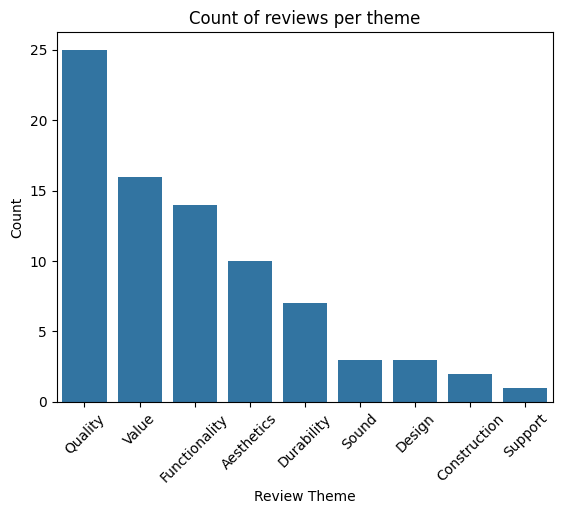

In [74]:
data = {'Quality': 25,
'Value':16  ,
'Functionality': 14,
'Aesthetics': 10,
'Durability': 7,
'Sound': 3 ,
'Design': 3,
'Construction': 2,
'Support': 1
}

theme = pd.DataFrame.from_dict(data, orient='index', columns=['Count'])

# Plot the histogram
sns.barplot(x=theme.index, y=theme['Count'])
plt.xlabel('Review Theme')
plt.ylabel('Count')
plt.title('Count of reviews per theme')
plt.xticks(rotation=45)
plt.show()

In [54]:
sentiment_mapping = {
    0: 'Neutral', 1: 'Positive', 2: 'Positive', 3: 'Positive', 4: 'Positive',
    5: 'Positive', 6: 'Positive', 7: 'Positive', 8: 'Positive', 9: 'Positive',
    10: 'Positive', 11: 'Neutral', 12: 'Neutral', 13: 'Positive', 14: 'Neutral',
    15: 'Neutral', 16: 'Positive', 17: 'Positive', 18: 'Positive', 19: 'Positive',
    20: 'Positive', 21: 'Positive', 22: 'Positive', 23: 'Positive', 24: 'Positive',
    25: 'Positive', 26: 'Positive', 27: 'Neutral', 28: 'Positive', 29: 'Positive',
    30: 'Positive', 31: 'Positive', 32: 'Positive', 33: 'Positive', 34: 'Neutral',
    35: 'Positive', 36: 'Negative', 37: 'Neutral', 38: 'Positive', 39: 'Positive',
    40: 'Positive', 41: 'Positive', 42: 'Positive', 43: 'Positive', 44: 'Positive',
    45: 'Positive', 46: 'Neutral', 47: 'Positive', 48: 'Neutral', 49: 'Positive',
    50: 'Positive'
}
# list_review_token = list_review_token.reset_index()
list_review_token['Sentiment']= list_review_token.index.map(sentiment_mapping)

list_review_token=list_review_token.drop(columns=['level_0','index'])
list_review_token

,Token_review,Sentiment
0,"[Not, much, to, write, about, here, ,, but, it...",Neutral
1,"[The, product, does, exactly, as, it, should, ...",Positive
2,"[The, primary, job, of, this, device, is, to, ...",Positive
3,"[Nice, windscreen, protects, my, MXL, mic, and...",Positive
4,"[This, pop, filter, is, great, ., It, looks, a...",Positive
5,"[So, good, that, I, bought, another, one, ., L...",Positive
6,"[I, have, used, monster, cables, for, years, ,...",Positive
7,"[I, now, use, this, cable, to, run, from, the,...",Positive
8,"[Perfect, for, my, Epiphone, Sheraton, II, ., ...",Positive
9,"[Monster, makes, the, best, cables, and, a, li...",Positive


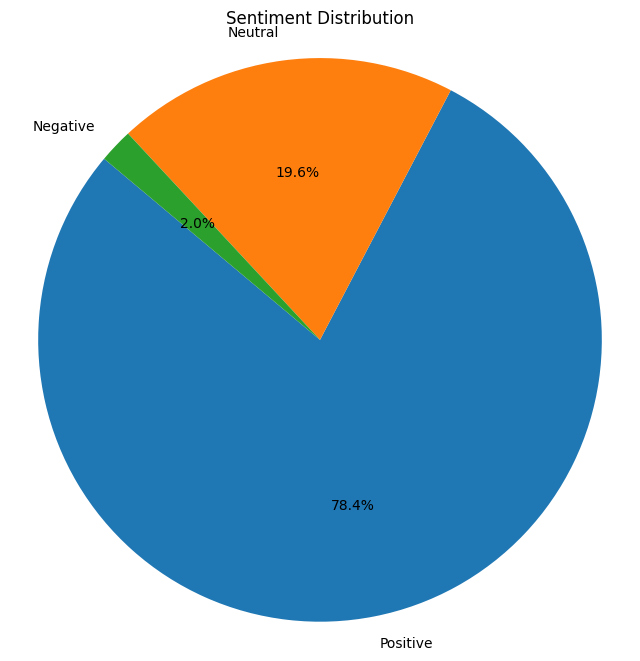

In [58]:
# Calculate sentiment counts
sentiment_counts = list_review_token['Sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()